# The diffusion equation - parallelized

In [1]:
# Note, this is only for jupyter notebooks
import ipyparallel as ipp
# Start the cluster
cluster = ipp.Cluster(engines="mpi", n=8)
client = cluster.start_and_connect_sync()
client.ids

Starting 8 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/8 [00:00<?, ?engine/s]

[0, 1, 2, 3, 4, 5, 6, 7]

In [2]:
%px %matplotlib inline

In [3]:
%%px
import numpy as np
import matplotlib.pyplot as plt
from mpi4py import MPI
#
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

print('Rank {}/{} is alive.'.format(rank, size))

[stdout:0] Rank 0/8 is alive.


[stdout:1] Rank 1/8 is alive.


[stdout:3] Rank 3/8 is alive.


[stdout:2] Rank 2/8 is alive.


[stdout:4] Rank 4/8 is alive.


[stdout:5] Rank 5/8 is alive.


[stdout:6] Rank 6/8 is alive.


[stdout:7] Rank 7/8 is alive.


#### Define the spatial grid and the time increment

In [7]:
%%px
nx = 1000
dx = 0.1
nt = 10000
dt = 0.001
D = 1 # diffusion constant

#### Domain decomposition

In [12]:
%%px
# Domain decomposition: set up domain boundaries
nx1 = rank*nx//size
nx2 = (rank+1)*nx//size

print('{}, Domain boundaries: {}-{}'.format(rank, nx1, nx2-1))

# We include one additional cell at the boundaries for communication purposes
x = np.arange(nx1-1, nx2+1)*dx

[stdout:0] 0, Domain boundaries: 0-124


[stdout:1] 1, Domain boundaries: 125-249


[stdout:2] 2, Domain boundaries: 250-374


[stdout:3] 3, Domain boundaries: 375-499


[stdout:4] 4, Domain boundaries: 500-624


[stdout:5] 5, Domain boundaries: 625-749


[stdout:6] 6, Domain boundaries: 750-874


[stdout:7] 7, Domain boundaries: 875-999


#### Initial condition: We use a Gaussian concentration profile initially

Out[2:12]: [<matplotlib.lines.Line2D at 0x1138933a0>]

Out[1:12]: [<matplotlib.lines.Line2D at 0x13fcc23a0>]

Out[4:12]: [<matplotlib.lines.Line2D at 0x10fdd43a0>]

Out[5:12]: [<matplotlib.lines.Line2D at 0x10bc533a0>]

Out[0:12]: [<matplotlib.lines.Line2D at 0x10ab933a0>]

Out[6:12]: [<matplotlib.lines.Line2D at 0x11612b3d0>]

Out[3:12]: [<matplotlib.lines.Line2D at 0x1196533a0>]

Out[7:12]: [<matplotlib.lines.Line2D at 0x127b103d0>]

[output:4]

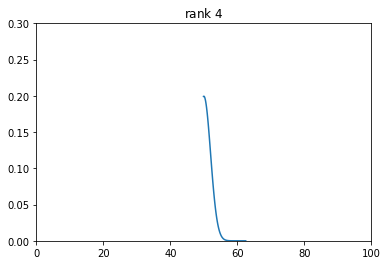

[output:0]

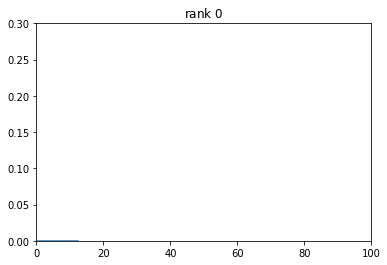

[output:2]

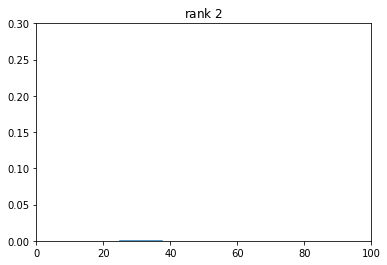

[output:1]

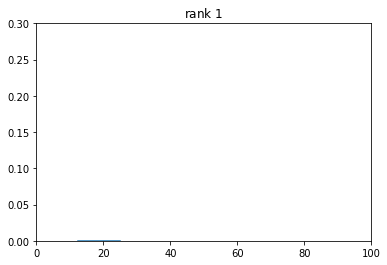

[output:6]

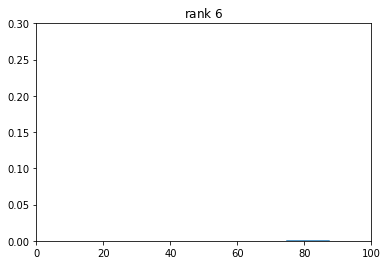

[output:3]

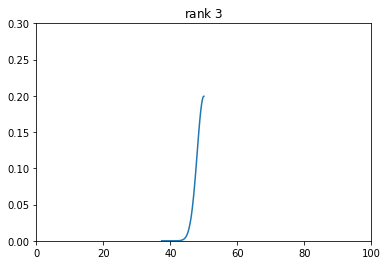

[output:5]

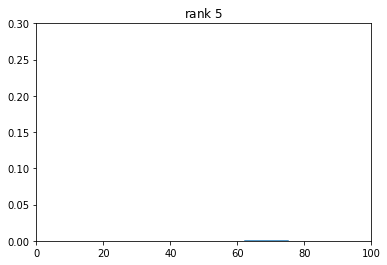

[output:7]

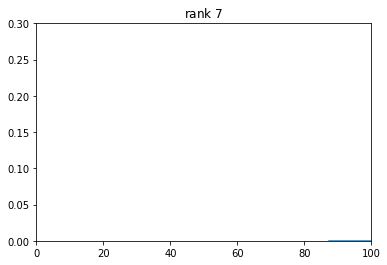

In [14]:
%%px
sigma0 = 20*dx
c = np.exp(-(x-nx*dx/2)**2/(2*sigma0**2)) / (np.sqrt(2*np.pi)*sigma0)

plt.title('rank ${}$'.format(rank))
plt.xlim(0, nx*dx)
plt.ylim(0, 0.3)
plt.plot(x, c)

#### Propagate in time

Out[1:13]: <matplotlib.legend.Legend at 0x13ff22100>

Out[3:13]: <matplotlib.legend.Legend at 0x1197a10a0>

Out[6:13]: <matplotlib.legend.Legend at 0x1162790d0>

Out[4:13]: <matplotlib.legend.Legend at 0x118021100>

Out[7:13]: <matplotlib.legend.Legend at 0x127c600d0>

Out[5:13]: <matplotlib.legend.Legend at 0x10bda1100>

Out[2:13]: <matplotlib.legend.Legend at 0x1139e1100>

%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

Out[0:13]: <matplotlib.legend.Legend at 0x10ace1100>

[output:6]

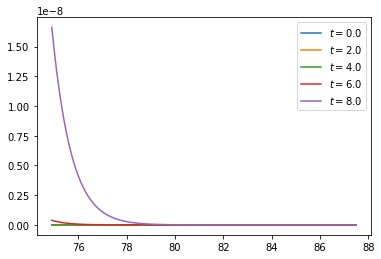

[output:0]

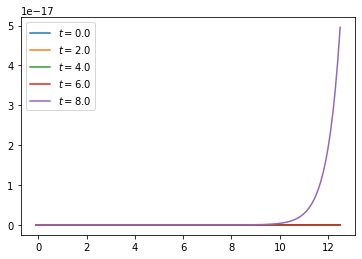

[output:4]

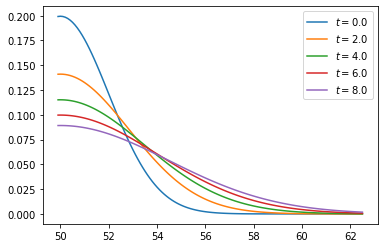

[output:5]

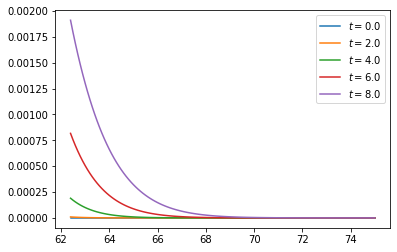

[output:2]

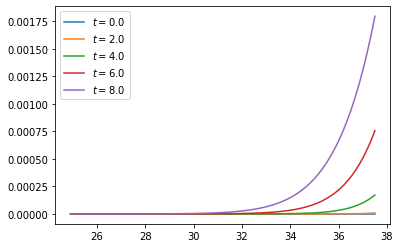

[output:1]

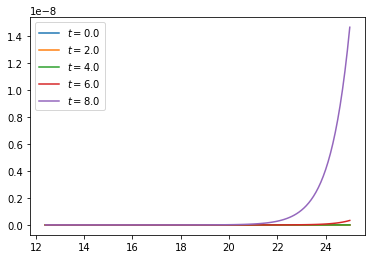

[output:3]

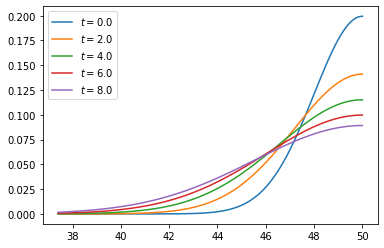

[output:7]

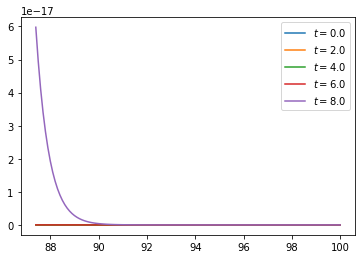

In [15]:
%%px
for t in range(nt):
    # Send to right, receive from left
    comm.Sendrecv(c[-2:-1], (rank+1)%size, recvbuf=c[:1], source=(rank-1)%size)
    # Send to left, receive from right
    comm.Sendrecv(c[1:2], (rank-1)%size, recvbuf=c[-1:], source=(rank+1)%size)
    if t % (nt/5) == 0:
        plt.plot(x, c, '-', label='$t={}$'.format(t*dt))

    d2c_dx2 = (np.roll(c, 1)-2*c+np.roll(c, -1))/(dx**2)
    c += D*d2c_dx2*dt
plt.legend(loc='best')

In [16]:
%%px
print(c.shape)

[stdout:0] (127,)


[stdout:1] (127,)


[stdout:3] (127,)


[stdout:2] (127,)


[stdout:4] (127,)


[stdout:5] (127,)


[stdout:6] (127,)


[stdout:7] (127,)


#### Gather all data on rank 0 and plot

[output:0]

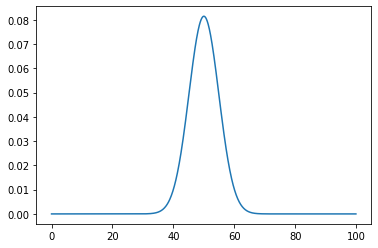

In [20]:
%%px
x_full_range = np.arange(nx)*dx
c_full_range = np.zeros(nx)
comm.Gather(c[1:-1], c_full_range, root=0)
if rank == 0:
    plt.plot(x_full_range, c_full_range, '-')

#### Gather during progation so we can plot the evolution of the concentration profile

In [ ]:
%%px
if rank == 0:
    x_full_range = np.arange(nx)*dx
    c_full_range = np.zeros(nx)
for t in range(nt):
    # Send to right, receive from left
    comm.Sendrecv(c[-2:-1], (rank+1)%size, recvbuf=c[:1], source=(rank-1)%size)
    # Send to left, receive from right
    comm.Sendrecv(c[1:2], (rank-1)%size, recvbuf=c[-1:], source=(rank+1)%size)
    if t % (nt/5) == 0:
        comm.Gather(c[1:-1], c_full_range, root=0)
        if rank == 0:
            plt.plot(x_full_range, c_full_range, '-', label='$t={}$'.format(t*dt))

    d2c_dx2 = (np.roll(c, 1)-2*c+np.roll(c, -1))/(dx**2)
    c += D*d2c_dx2*dt
if rank == 0:
    plt.legend(loc='best')

In [ ]:
%%px
if rank == 1: print(c_full_range)

In [11]:
%%px
print('Process {} knows about dx = {}'.format(rank,dx))

[stdout:0] Process 0 knows about dx = 0.1


[stdout:1] Process 1 knows about dx = 0.1


[stdout:2] Process 2 knows about dx = 0.1


[stdout:3] Process 3 knows about dx = 0.1


[stdout:4] Process 4 knows about dx = 0.1


[stdout:5] Process 5 knows about dx = 0.1


[stdout:6] Process 6 knows about dx = 0.1


[stdout:7] Process 7 knows about dx = 0.1


In [18]:
%%px 
c_full_range

Out[2:16]: 
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.

Out[1:16]: 
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.

Out[0:16]: 
array([4.14813651e-24, 4.23718670e-24, 4.50801098e-24, 4.97177576e-24,
       5.64758141e-24, 6.56321621e-24, 7.75625136e-24, 9.27551839e-24,
       1.11830244e-23, 1.35563770e-23, 1.64918092e-23, 2.01079175e-23,
       2.45502517e-23, 2.99969247e-23, 3.66654517e-23, 4.48210662e-23,
       5.47868186e-23, 6.69558236e-23, 8.18060985e-23, 9.99185286e-23,
       1.21998602e-22, 1.48902691e-22, 1.81669808e-22, 2.21559971e-22,
       2.70100510e-22, 3.29141956e-22, 4.00925440e-22, 4.88163960e-22,
       5.94140301e-22, 7.22824993e-22, 8.79018319e-22, 1.06852123e-21,
       1.29834090e-21, 1.57693797e-21, 1.91452359e-21, 2.32341635e-21,
       2.81847081e-21, 3.41759194e-21, 4.14235223e-21, 5.01873177e-21,
       6.07800537e-21, 7.35780546e-21, 8.90339504e-21, 1.07691915e-20,
       1.30205901e-20, 1.57361447e-20, 1.90101749e-20, 2.29558818e-20,
       2.77090692e-20, 3.34325867e-20, 4.03216322e-20, 4.86100765e-20,
       5.85780049e-20, 7.05607057e-20, 8.49593767e-20, 1.02253876

Out[3:16]: 
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.

Out[7:16]: 
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.

Out[4:16]: 
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.

Out[5:16]: 
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.

Out[6:16]: 
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.